In [14]:
import numpy as np
import pandas as pd
import skfuzzy as fuzz
from skfuzzy import control as ctrl
import matplotlib.pyplot as plt
%matplotlib inline

data = pd.read_csv('data.csv')

percentage = 0.3
data[:int(len(data)*percentage):]

,title,type,genres,releaseYear,imdbAverageRating,imdbNumVotes,availableCountries
0,The Fifth Element,movie,"Action, Adventure, Sci-Fi",1997.0,7.6,519248.0,"AT, CH, DE"
1,Kill Bill: Vol. 1,movie,"Action, Crime, Thriller",2003.0,8.2,1228454.0,"AE, AL, AO, AT, AU, AZ, BG, BH, BY, CI, CM, CZ..."
2,Jarhead,movie,"Biography, Drama, War",2005.0,7.0,212748.0,"AD, AE, AG, AO, BH, BM, BR, BS, BZ, CI, CM, CO..."
3,Unforgiven,movie,"Drama, Western",1992.0,8.2,446602.0,"AU, BA, BG, CZ, HR, HU, MD, ME, MK, NZ, PL, RO..."
4,Eternal Sunshine of the Spotless Mind,movie,"Drama, Romance, Sci-Fi",2004.0,8.3,1113480.0,"AD, AE, AG, AL, AO, AR, AU, AZ, BA, BB, BE, BG..."
...,...,...,...,...,...,...,...
5681,Facet (nie)potrzebny od zaraz,movie,"Comedy, Drama, Music",2014.0,4.4,398.0,"AT, BE, BG, BM, CH, CY, CZ, DE, DK, EE, ES, FI..."
5682,The Smile of a Child,movie,"Comedy, Drama, Music",1969.0,4.8,44.0,"AL, AT, BA, BE, BG, CH, CZ, DE, DK, EE, FI, FR..."
5683,Kundo: Age of the Rampant,movie,"Action, Drama",2014.0,6.8,3954.0,KR
5684,The Mummy,movie,"Action, Adventure, Fantasy",2017.0,5.4,211329.0,"AD, AE, AG, AL, AO, AR, AT, AU, AZ, BA, BB, BE..."


In [15]:
# Determine the data ranges
min_year = data['releaseYear'].min()
max_year = data['releaseYear'].max()
max_votes = data['imdbNumVotes'].max()

print(f"Release Year Range: {min_year} - {max_year}")
print(f"Number of Votes Range: 0 - {max_votes}")

# Define the universal variables
imdb_rating = ctrl.Antecedent(np.arange(0, 10.1, 0.1), 'imdb_rating')
release_year = ctrl.Antecedent(np.arange(min_year, max_year + 1, 1), 'release_year')
num_votes = ctrl.Antecedent(np.arange(0, max_votes + 1, 10000), 'num_votes')
movie_quality = ctrl.Consequent(np.arange(0, 11, 1), 'movie_quality')

Release Year Range: 1913.0 - 2024.0
Number of Votes Range: 0 - 2981119.0


c:\Users\Malv\Downloads\class\ai lab\ai-venv\Lib\site-packages\skfuzzy\control\fuzzyvariable.py:125: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


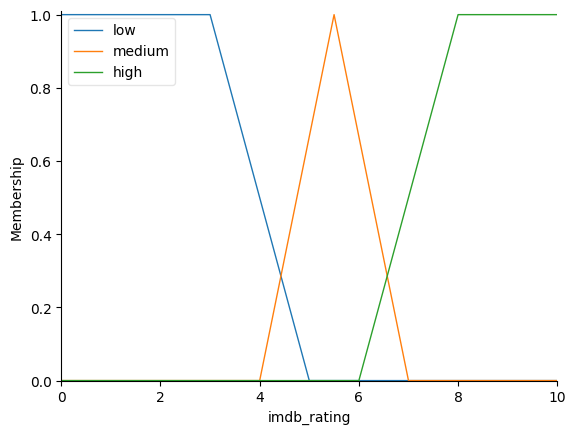

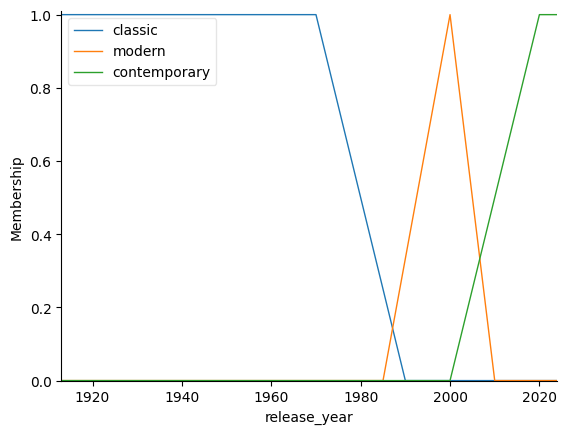

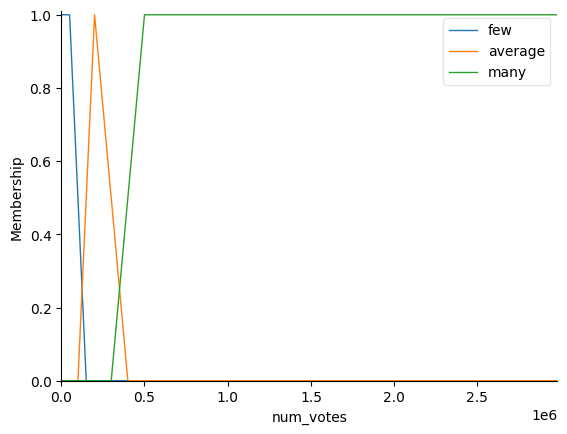

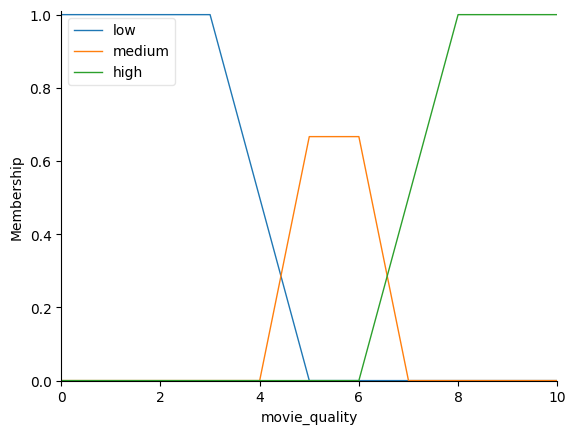

In [16]:
# IMDb Rating Membership Functions
imdb_rating['low'] = fuzz.trapmf(imdb_rating.universe, [0, 0, 3, 5])
imdb_rating['medium'] = fuzz.trimf(imdb_rating.universe, [4, 5.5, 7])
imdb_rating['high'] = fuzz.trapmf(imdb_rating.universe, [6, 8, 10, 10])

# Release Year Membership Functions
release_year['classic'] = fuzz.trapmf(release_year.universe, [min_year, min_year, 1970, 1990])
release_year['modern'] = fuzz.trimf(release_year.universe, [1985, 2000, 2010])
release_year['contemporary'] = fuzz.trapmf(release_year.universe, [2000, 2020, max_year, max_year])

# Number of Votes Membership Functions
num_votes['few'] = fuzz.trapmf(num_votes.universe, [0, 0, 50000, 150000])
num_votes['average'] = fuzz.trimf(num_votes.universe, [100000, 200000, 400000])
num_votes['many'] = fuzz.trapmf(num_votes.universe, [300000, 500000, max_votes, max_votes])

# Movie Quality Membership Functions
movie_quality['low'] = fuzz.trapmf(movie_quality.universe, [0, 0, 3, 5])
movie_quality['medium'] = fuzz.trimf(movie_quality.universe, [4, 5.5, 7])
movie_quality['high'] = fuzz.trapmf(movie_quality.universe, [6, 8, 10, 10])

imdb_rating.view()
release_year.view()
num_votes.view()
movie_quality.view()
plt.show()

In [17]:
# Rule definitions
rule1 = ctrl.Rule(imdb_rating['high'] & num_votes['many'], movie_quality['high'])
rule2 = ctrl.Rule(imdb_rating['medium'] & num_votes['average'], movie_quality['medium'])
rule3 = ctrl.Rule(imdb_rating['low'] & num_votes['few'], movie_quality['low'])
rule4 = ctrl.Rule(imdb_rating['high'] & release_year['classic'], movie_quality['high'])
rule5 = ctrl.Rule(imdb_rating['medium'] & release_year['modern'], movie_quality['medium'])
rule6 = ctrl.Rule(imdb_rating['low'] | num_votes['few'], movie_quality['low'])
rule7 = ctrl.Rule(imdb_rating['high'], movie_quality['high'])
rule8 = ctrl.Rule(imdb_rating['medium'], movie_quality['medium'])
rule9 = ctrl.Rule(imdb_rating['low'], movie_quality['low'])

# Build the control system with all the rules
movie_quality_ctrl = ctrl.ControlSystem([
    rule1, rule2, rule3, rule4, rule5, rule6, rule7, rule8, rule9
])

# Function to compute movie quality
def compute_movie_quality(row):
    # Create a new simulation instance for each row
    movie_quality_simulation = ctrl.ControlSystemSimulation(movie_quality_ctrl)

    # Initialize variables
    imdb_rating_value = None
    release_year_value = None
    num_votes_value = None

    try:
        # Set input values
        imdb_rating_value = row['imdbAverageRating']
        release_year_value = row['releaseYear']
        num_votes_value = row['imdbNumVotes']

        # Clip inputs to universes
        imdb_rating_value = np.clip(imdb_rating_value, imdb_rating.universe[0], imdb_rating.universe[-1])
        release_year_value = np.clip(release_year_value, release_year.universe[0], release_year.universe[-1])
        num_votes_value = np.clip(num_votes_value, num_votes.universe[0], num_votes.universe[-1])

        # Set inputs
        movie_quality_simulation.input['imdb_rating'] = imdb_rating_value
        movie_quality_simulation.input['release_year'] = release_year_value
        movie_quality_simulation.input['num_votes'] = num_votes_value

        # Compute the fuzzy result
        movie_quality_simulation.compute()

        return movie_quality_simulation.output['movie_quality']

    except Exception as ex:
        print(f"Error computing for row {row.name}: {ex}")
        print(f"Inputs: imdb_rating={imdb_rating_value}, release_year={release_year_value}, num_votes={num_votes_value}")
        return np.nan

# Apply the fuzzy logic model to the dataset
data['movie_quality_score'] = data.apply(compute_movie_quality, axis=1)

# Display the updated dataset with the new column
data.head()

,title,type,genres,releaseYear,imdbAverageRating,imdbNumVotes,availableCountries,movie_quality_score
0,The Fifth Element,movie,"Action, Adventure, Sci-Fi",1997.0,7.6,519248.0,"AT, CH, DE",8.366667
1,Kill Bill: Vol. 1,movie,"Action, Crime, Thriller",2003.0,8.2,1228454.0,"AE, AL, AO, AT, AU, AZ, BG, BH, BY, CI, CM, CZ...",8.444444
2,Jarhead,movie,"Biography, Drama, War",2005.0,7.0,212748.0,"AD, AE, AG, AO, BH, BM, BR, BS, BZ, CI, CM, CO...",8.238095
3,Unforgiven,movie,"Drama, Western",1992.0,8.2,446602.0,"AU, BA, BG, CZ, HR, HU, MD, ME, MK, NZ, PL, RO...",8.444444
4,Eternal Sunshine of the Spotless Mind,movie,"Drama, Romance, Sci-Fi",2004.0,8.3,1113480.0,"AD, AE, AG, AL, AO, AR, AU, AZ, BA, BB, BE, BG...",8.444444


In [18]:
# Define a function to classify the movies
def classify_movie(score):
    if score >= 6.0:
        return 'High'
    elif score >= 4.0:
        return 'Medium'
    else:
        return 'Low'

# Apply the classification
data['movie_quality_category'] = data['movie_quality_score'].apply(classify_movie)

In [19]:
# Display the top 10 movies with the highest quality scores
top_movies = data.sort_values(by='movie_quality_score', ascending=False)
# save the top movies to a csv file
top_movies.to_csv('top-movies.csv', index=False)

top_movies[['title', 'imdbAverageRating', 'releaseYear', 'imdbNumVotes', 'movie_quality_score', 'movie_quality_category']].head(10)

,title,imdbAverageRating,releaseYear,imdbNumVotes,movie_quality_score,movie_quality_category
1,Kill Bill: Vol. 1,8.2,2003.0,1228454.0,8.444444,High
11,Million Dollar Baby,8.1,2004.0,736377.0,8.444444,High
3,Unforgiven,8.2,1992.0,446602.0,8.444444,High
4,Eternal Sunshine of the Spotless Mind,8.3,2004.0,1113480.0,8.444444,High
5,Amores Perros,8.0,2000.0,257839.0,8.444444,High
31,Snatch,8.2,2000.0,931865.0,8.444444,High
32,Scarface,8.3,1983.0,945439.0,8.444444,High
7,2001: A Space Odyssey,8.3,1968.0,741185.0,8.444444,High
35,The Lord of the Rings: The Fellowship of the Ring,8.9,2001.0,2069609.0,8.444444,High
14,Before Sunrise,8.1,1995.0,351396.0,8.444444,High


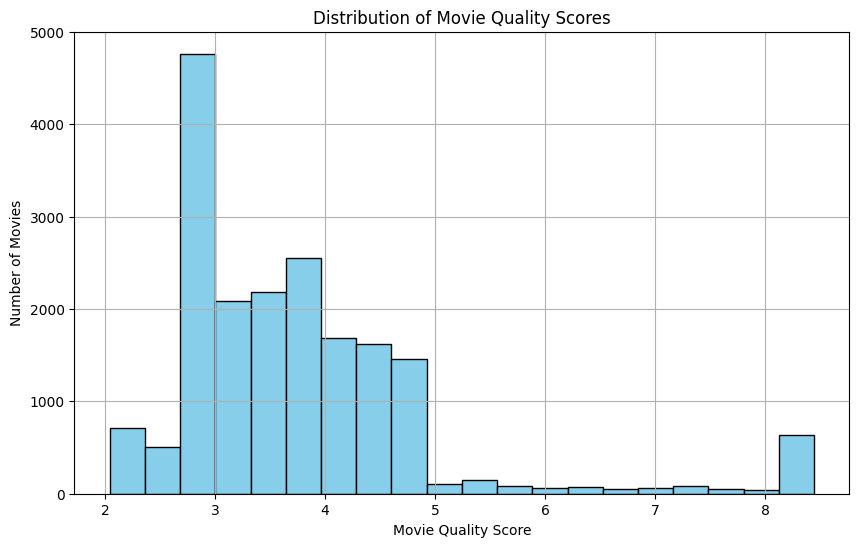

In [20]:
# Plot the distribution of movie quality scores
plt.figure(figsize=(10,6))
plt.hist(data['movie_quality_score'].dropna(), bins=20, color='skyblue', edgecolor='black')
plt.title('Distribution of Movie Quality Scores')
plt.xlabel('Movie Quality Score')
plt.ylabel('Number of Movies')
plt.grid(True)
plt.show()

Movie Quality Category Counts:
movie_quality_category
Low       12819
Medium     5092
High       1044
Name: count, dtype: int64


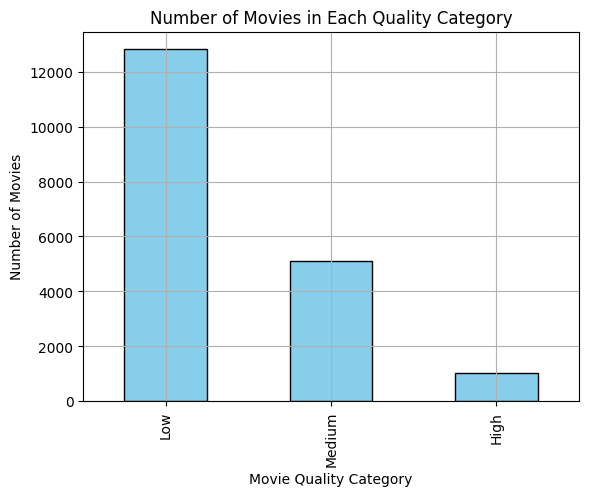

In [21]:
# Count the number of movies in each category
category_counts = data['movie_quality_category'].value_counts()
print("Movie Quality Category Counts:")
print(category_counts)

# Plot the counts
category_counts.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title('Number of Movies in Each Quality Category')
plt.xlabel('Movie Quality Category')
plt.ylabel('Number of Movies')
plt.grid(True)
plt.show()